In [3]:
import os
import json
import numpy as np
from skimage.draw import disk
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

def create_mask_from_json(json_data, shape):
    mask = np.zeros(shape, dtype=np.float32)
    for item in json_data:
        rr, cc = disk((item['y'], item['x']), item['radius'], shape=shape)
        mask[rr, cc] = 1.0
    return mask

def resize_labels(labels, original_size, new_size):
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels

def load_images_and_labels(image_paths, label_dir, new_size):
    original_size = (1024, 1024)  # Original size of the images and labels
    images = []
    masks = []

    for image_path in image_paths:
        # Extract filename without extension to match with the label
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        label_file = os.path.join(label_dir, base_filename + '.json')

        # Load and resize image
        image = img_to_array(load_img(image_path, color_mode='rgb', target_size=new_size))
        images.append(image / 255.0)  # Normalizing to [0, 1]

        # Load and resize corresponding label
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size, new_size)
        mask = create_mask_from_json(resized_json_data, shape=new_size)
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, *new_size, 1)



def create_loocv_folds(image_files, augmented_image_dir, num_augmentations = 20):
    folds = []
    n = len(image_files)

    for i in range(n):
        test_image = image_files[i]
        
        # Ensure validation images are different from the test image and rotate them
        val_indices = [(i + 1) % n, (i + 2) % n]
        validation_images = [image_files[j] for j in val_indices]

        # Remaining images for training, excluding the test and validation images
        train_images = [img for idx, img in enumerate(image_files) if idx not in [i, val_indices[0], val_indices[1]]]

        # Augmented images for training
        augmented_train_images = [os.path.join(augmented_image_dir, os.path.basename(img).replace('.png', f'_aug_{k}.png')) 
                                  for img in train_images for k in range(num_augmentations)]

        folds.append((augmented_train_images, [test_image], validation_images))

    return folds

def create_10fold_cv_folds(image_files, augmented_image_dir, n_splits=10, num_augmentations = 20):
    # Initialize the KFold mechanism
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    folds = []
    n = len(image_files)
    
    for train_val_indices, test_indices in kf.split(image_files):
        # Separate the original dataset into training+validation and testing sets
        test_images = [image_files[i] for i in test_indices]
        
        # The training+validation set (will further split into actual train and validation sets)
        train_val_images = [image_files[i] for i in train_val_indices]
        
        # We take the first 90% of the train_val_indices for training and the remaining 10% for validation
        # Adjust the percentage as needed for training vs. validation split
        split_idx = int(len(train_val_images) * 0.9)
        train_images, validation_images = train_val_images[:split_idx], train_val_images[split_idx:]
        
        # Augmented images for training
        augmented_train_images = [os.path.join(augmented_image_dir, os.path.basename(img).replace('.png', f'_aug_{k}.png')) 
                                  for img in train_images for k in range(num_augmentations)]
        
        folds.append((augmented_train_images, test_images, validation_images))
    
    return folds



In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation, SeparableConv2D

# def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
#     # A conv block consists of two convolutions, each followed by a batch normalization and a relu activation.
#     x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
#     if do_batch_norm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
#     x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
#     if do_batch_norm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
    x = SeparableConv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(512, 512, 3), num_filters=16, depth=2, dropout=0.5, batch_norm=True):
    # INPUT LAYER
    inputs = Input(input_size)
    # CONTRACTING PATH
    conv_blocks = []
    x = inputs
    for i in range(depth):
        x = conv_block(x, num_filters * (2**i), do_batch_norm=batch_norm)
        conv_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout)(x)

    # BOTTLENECK
    x = conv_block(x, num_filters * (2**(depth)), do_batch_norm=batch_norm)
    
    # EXPANSIVE PATH
    for i in reversed(range(depth)):
        num_filters_exp = num_filters * (2**i)
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, conv_blocks[i]], axis=3)
        x = conv_block(x, num_filters_exp, do_batch_norm=batch_norm)

    # FINAL CONVOLUTION
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [5]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import os

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 0:
        return lr
    elif epoch < 10 and epoch%2 == 0:
        return lr
    elif epoch < 20 and epoch%2 == 0:
        return lr * tf.math.exp(-0.2)
    elif epoch > 30:
        return lr * tf.math.exp(-0.5)
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

log_dir = "./tensorboard_logs"

def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        return K.mean(weighted_bce)
    return loss

def train_unet(model, train_images, train_masks, val_images, val_masks, epochs=300, batch_size=32, checkpoint_path='pixel_cores.hdf5'):
    # Define the custom loss function
    custom_loss = weighted_binary_crossentropy(zero_weight=1, one_weight=1)

    # Check if a previous checkpoint exists
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from checkpoint: {checkpoint_path}")
        # Load the model with the custom loss function
        model = load_model(checkpoint_path, custom_objects={'loss': custom_loss})
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Compile the model with the custom loss function
    model.compile(optimizer=Adam(learning_rate=5e-5), loss=custom_loss, metrics=['AUC', 'accuracy', 'Precision', 'Recall'])
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
    
    # Define the TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Fit the model with the given training and validation data
    history = model.fit(
        x=train_images, 
        y=train_masks, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1, 
        validation_data=(val_images, val_masks), 
        callbacks=[model_checkpoint, tensorboard_callback, lr_scheduler, early_stopping]
    )
    
    return model



In [6]:
import os
import numpy as np
import csv  # Import the csv module

original_image_dir = './TMA_WSI_Padded_PNGs'
augmented_image_dir = './augmented_images'
original_label_dir = './TMA_WSI_Labels_updated'
augmented_label_dir = './augmented_labels'

# Use list comprehension to create the list of file paths
original_image_files = [os.path.join(original_image_dir, file) for file in sorted(
    os.listdir(original_image_dir)) if file.endswith('.png')]

folds = create_10fold_cv_folds(original_image_files, augmented_image_dir)


In [7]:
folds

[(['./augmented_images/1_aug_0.png',
   './augmented_images/1_aug_1.png',
   './augmented_images/1_aug_2.png',
   './augmented_images/1_aug_3.png',
   './augmented_images/1_aug_4.png',
   './augmented_images/1_aug_5.png',
   './augmented_images/1_aug_6.png',
   './augmented_images/1_aug_7.png',
   './augmented_images/1_aug_8.png',
   './augmented_images/1_aug_9.png',
   './augmented_images/1_aug_10.png',
   './augmented_images/1_aug_11.png',
   './augmented_images/1_aug_12.png',
   './augmented_images/1_aug_13.png',
   './augmented_images/1_aug_14.png',
   './augmented_images/1_aug_15.png',
   './augmented_images/1_aug_16.png',
   './augmented_images/1_aug_17.png',
   './augmented_images/1_aug_18.png',
   './augmented_images/1_aug_19.png',
   './augmented_images/10_aug_0.png',
   './augmented_images/10_aug_1.png',
   './augmented_images/10_aug_2.png',
   './augmented_images/10_aug_3.png',
   './augmented_images/10_aug_4.png',
   './augmented_images/10_aug_5.png',
   './augmented_images

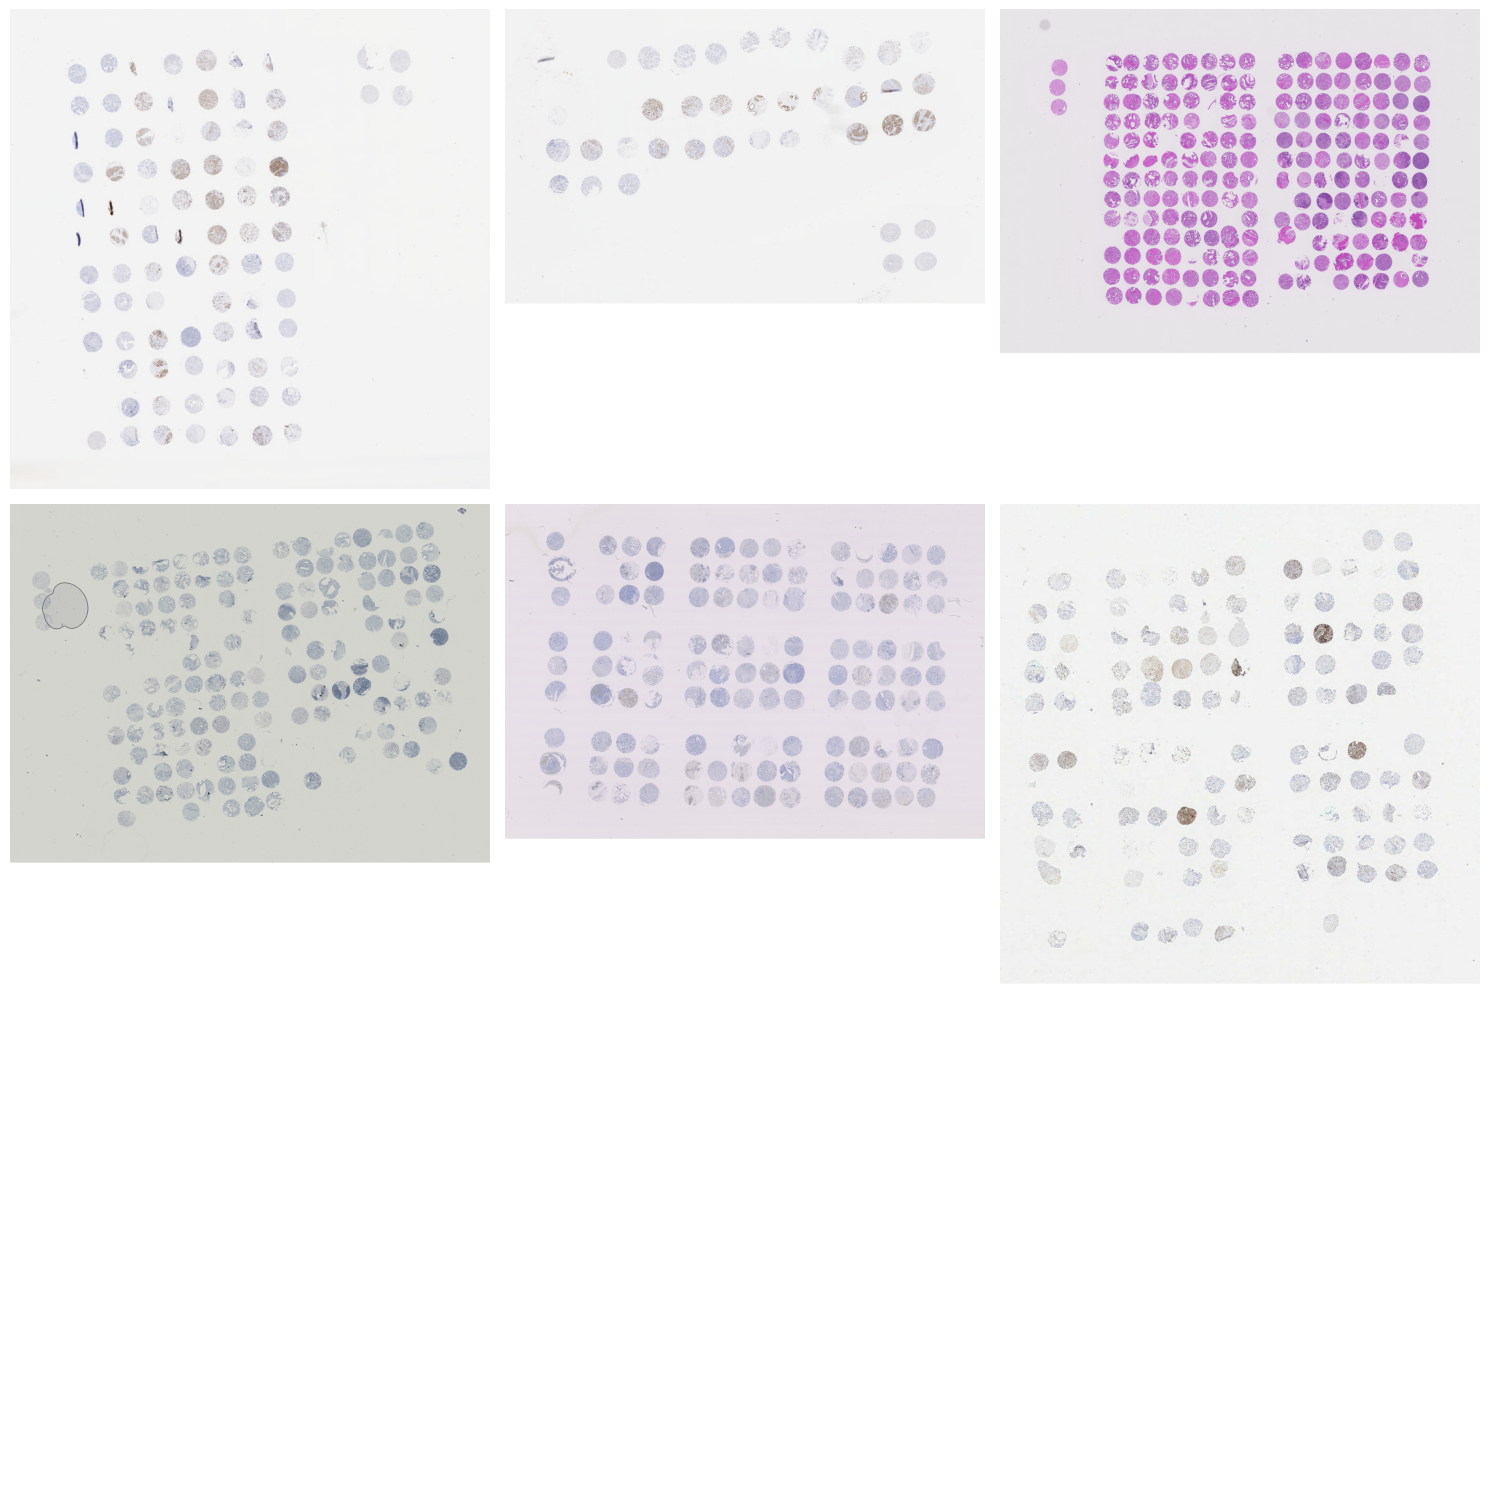

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images(image_paths):
    """
    Plots a set of images given their file paths.
    
    Parameters:
    - image_paths: A list of strings, where each string is the file path to an image.
    """
    # Number of images
    n_images = len(image_paths)
    
    # Determine the grid size (square root of the number of images, rounded up)
    grid_size = int(n_images ** 0.5) + (1 if n_images ** 0.5 % 1 else 0)
    
    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    # Flatten the array of axes (subplots) for easy indexing
    axes_flat = axes.flatten()
    
    # Loop through the image paths and the corresponding axis
    for ax, image_path in zip(axes_flat, image_paths):
        # Load and display the image
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes for each subplot
    
    # Hide any unused subplots
    for i in range(n_images, len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_paths = folds[8][2]
plot_images(image_paths)


In [9]:
# Create the model
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 512, 512, 16)         91        ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['separable_conv2d[0][0]']    
 Normalization)                                                                                   
                                                                                              

In [53]:
import csv

# Define the path to the CSV file
csv_file = 'model_evaluation_results.csv'

# Open the CSV file in append mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Fold', 'Loss', 'AUC', 'Accuracy', 'Precision', 'Recall'])

    # Iterate over each fold
    for i, fold in enumerate(folds):
        # Load the checkpointed model for the fold
        model_path = f"pixel_core_fold_{i+1}.hdf5"
        loaded_model = tf.keras.models.load_model(model_path, custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

        # Unpack the fold
        train_image, test_image, val_images = fold

        # Load the test images and masks
        test_images, test_masks = load_images_and_labels(test_image, original_label_dir, (512,512))

        # Evaluate the model on the test set
        loss, auc, accuracy, precision, recall = loaded_model.evaluate(test_images, test_masks)

        # Write the evaluation metrics to the CSV file
        writer.writerow([i+1, loss, auc, accuracy, precision, recall])
    

        # Flush the changes to the CSV file
        file.flush()


1/1 [==============================] - 1s 521ms/step - loss: 0.2305 - auc: 0.9623 - accuracy: 0.9274 - precision: 0.8850 - recall: 0.7709


In [69]:
import csv
import os

# Assuming the existence of these functions and variables:
# load_images_and_labels, folds, augmented_label_dir, original_label_dir, unet, train_unet

# Evaluation metrics initialization
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

new_size = (512, 512)

start_fold = 2  # Set this to your desired starting fold number

# Open a CSV file to write the results
with open('model_evaluation_results.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    # Check if the file is empty by seeking to the end and getting the position
    file.seek(0, os.SEEK_END)
    if file.tell() == 0:
        # File is empty, write the header
        writer.writerow(['Fold', 'Loss', 'AUC', 'Accuracy', 'Precision', 'Recall'])

    file.flush() 
    indices = range(start_fold, 11)  # Adjusted to start from start_fold
    # Iterate over each fold
    for index in indices:
        fold = folds[index - 1]
        augmented_train_images, test_image, validation_images = fold

        # Load and preprocess images and labels
        train_images, train_masks = load_images_and_labels(
            augmented_train_images, augmented_label_dir, new_size)
        test_images, test_masks = load_images_and_labels(
            test_image, original_label_dir, new_size)
        val_images, val_masks = load_images_and_labels(
            validation_images, original_label_dir, new_size)

        # Create a new instance of the model
        model = unet()

        # Train the model
        trained_model = train_unet(model, train_images, train_masks, val_images, val_masks, 150, 32, f"pixel_core_fold_{index}.hdf5")

        # Evaluate the model on the test set
        loss, auc, accuracy, precision, recall = trained_model.evaluate(
            test_images, test_masks)

        # Store the evaluation metrics
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # Write the fold results to the CSV file
        writer.writerow([index, loss, auc, accuracy, precision, recall])
        file.flush()


Loading weights from checkpoint: pixel_core_fold_2.hdf5
Epoch 1/150
32/32 [==============================] - ETA: 0s - loss: 0.1497 - auc: 0.9772 - accuracy: 0.9471 - precision: 0.8792 - recall: 0.8465 
Epoch 1: val_loss improved from inf to 0.53709, saving model to pixel_core_fold_2.hdf5
32/32 [==============================] - 385s 12s/step - loss: 0.1497 - auc: 0.9772 - accuracy: 0.9471 - precision: 0.8792 - recall: 0.8465 - val_loss: 0.5371 - val_auc: 0.9139 - val_accuracy: 0.8668 - val_precision: 0.5359 - val_recall: 0.9075 - lr: 5.0000e-08
Epoch 2/150
32/32 [==============================] - ETA: 0s - loss: 0.1506 - auc: 0.9769 - accuracy: 0.9468 - precision: 0.8781 - recall: 0.8464 
Epoch 2: val_loss did not improve from 0.53709
32/32 [==============================] - 377s 12s/step - loss: 0.1506 - auc: 0.9769 - accuracy: 0.9468 - precision: 0.8781 - recall: 0.8464 - val_loss: 0.6452 - val_auc: 0.9033 - val_accuracy: 0.7808 - val_precision: 0.4040 - val_recall: 0.9382 - lr: 5.0

KeyboardInterrupt: 

In [55]:
import pandas as pd

results = pd.read_csv('model_evaluation_results.csv') 

results.describe()

,Fold,Loss,AUC,Accuracy,Precision,Recall
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,0.199782,0.966438,0.926263,0.864441,0.764396
std,3.02765,0.079384,0.030139,0.031071,0.101622,0.160807
min,1.00000,0.129794,0.882597,0.865384,0.586440,0.378800
25%,3.25000,0.142416,0.969656,0.920398,0.873218,0.739637
50%,5.50000,0.183095,0.976972,0.942170,0.886104,0.793000
75%,7.75000,0.226656,0.979393,0.946190,0.914200,0.861691
max,10.00000,0.394235,0.984359,0.952200,0.946821,0.932339


In [10]:
# Get the model and the folds training and validation data from the 9th fold

# Load the checkpointed model for the fold
model_path = "pixel_core_fold_9_combined.hdf5"
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

# Combine the validation and training sets for the 9th fold. Ensure that we're using the augmented versions of both the training and validation images

# Unpack the fold
train_images, test_image, val_images = folds[8]

# Load the training and validation images and masks
train_images, train_masks = load_images_and_labels(train_images, augmented_label_dir, (512,512))

# Load the augmented versions of the validation images and masks
augmented_val_images = [os.path.join(augmented_image_dir, os.path.basename(img).replace('.png', f'_aug_{k}.png')) for img in val_images for k in range(20)]

augmented_val_images, augmented_val_masks = load_images_and_labels(augmented_val_images, augmented_label_dir, (512,512))

augmented_test_images = [os.path.join(augmented_image_dir, os.path.basename(img).replace('.png', f'_aug_{k}.png')) for img in test_image for k in range(20)]

augmented_test_images, augmented_test_masks = load_images_and_labels(augmented_test_images, augmented_label_dir, (512,512))

# Load test images and masks
test_images, test_masks = load_images_and_labels(test_image, original_label_dir, (512,512))


# Train the model on the combined training and validation sets
trained_model = train_unet(loaded_model, np.concatenate([train_images, augmented_val_images, augmented_test_images]), np.concatenate([train_masks, augmented_val_masks, augmented_test_masks]), test_images, test_masks, 150, 32, f"final_model.hdf5")


Loading weights from checkpoint: final_model.hdf5
Epoch 1/150
40/40 [==============================] - ETA: 0s - loss: 0.1250 - auc: 0.9831 - accuracy: 0.9534 - precision: 0.8990 - recall: 0.8528
Epoch 1: val_loss improved from inf to 0.37823, saving model to final_model.hdf5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 367s 9s/step - loss: 0.1250 - auc: 0.9831 - accuracy: 0.9534 - precision: 0.8990 - recall: 0.8528 - val_loss: 0.3782 - val_auc: 0.9873 - val_accuracy: 0.8113 - val_precision: 0.4510 - val_recall: 0.9921 - lr: 5.0000e-05
Epoch 2/150
40/40 [==============================] - ETA: 0s - loss: 0.1239 - auc: 0.9835 - accuracy: 0.9538 - precision: 0.9004 - recall: 0.8530
Epoch 2: val_loss did not improve from 0.37823
40/40 [==============================] - 366s 9s/step - loss: 0.1239 - auc: 0.9835 - accuracy: 0.9538 - precision: 0.9004 - recall: 0.8530 - val_loss: 0.4315 - val_auc: 0.9857 - val_accuracy: 0.7766 - val_precision: 0.4096 - val_recall: 0.9941 - lr: 5.0000e-05
Epoch 3/150
40/40 [==============================] - ETA: 0s - loss: 0.1236 - auc: 0.9834 - accuracy: 0.9539 - precision: 0.9005 - recall: 0.8537
Epoch 3: val_loss improved from 0.37823 to 0.32702, saving model to final_model.hdf5
40/40 [==============================] - 371s 9s/step 

KeyboardInterrupt: 

In [11]:
!tensorflowjs_converter --input_format keras ./Jupyter_Notebooks/final_model.hdf5 model/

